<a href="https://colab.research.google.com/github/fms-faisal/Impact-of-Digital-Image-Processing-on-Model-Performance/blob/main/model_selection_part_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **InceptionV3**

Mounted at /content/drive
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=I


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-1-0fb46e17c2b3>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 1.8996  Acc: 0.6295


Val Loss: 0.8638  Acc: 0.7385

Epoch 2/10 ====================


Train Loss: 0.7977  Acc: 0.8463


Val Loss: 0.7352  Acc: 0.7748

Epoch 3/10 ====================


Train Loss: 0.6090  Acc: 0.8822


Val Loss: 0.6222  Acc: 0.8087

Epoch 4/10 ====================


Train Loss: 0.5063  Acc: 0.9005


Val Loss: 0.6003  Acc: 0.8160

Epoch 5/10 ====================


Train Loss: 0.4443  Acc: 0.9080


Val Loss: 0.5622  Acc: 0.8208

Epoch 6/10 ====================


Train Loss: 0.4069  Acc: 0.9153


Val Loss: 0.5138  Acc: 0.8402

Epoch 7/10 ====================


Train Loss: 0.3809  Acc: 0.9201


Val Loss: 0.5248  Acc: 0.8329

Epoch 8/10 ====================


Train Loss: 0.3554  Acc: 0.9243


Val Loss: 0.4882  Acc: 0.8475

Epoch 9/10 ====================


Train Loss: 0.3367  Acc: 0.9286


Val Loss: 0.4835  Acc: 0.8523

Epoch 10/10 ====================


Train Loss: 0.3351  Acc: 0.9255


Val Loss: 0.4852  Acc: 0.8523

Training complete in 7m 59s
Best validation accuracy: 0.8523



--- Test Metrics ---
Test Accuracy : 0.9604
Precision     : 0.9631
Recall        : 0.9604
F1 Score      : 0.9602

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.80      0.89        20
                  Black Hairy       0.95      1.00      0.98        20
                      Cutworm       0.83      1.00      0.91        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       1.00      0.86      0.93        22
                   Jute Hairy       0.89      0.85      0.87        20
                Jute Red Mite       0.96      1.00      0.98        24
              Jute Semilooper       0.83      0.90      0.86        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

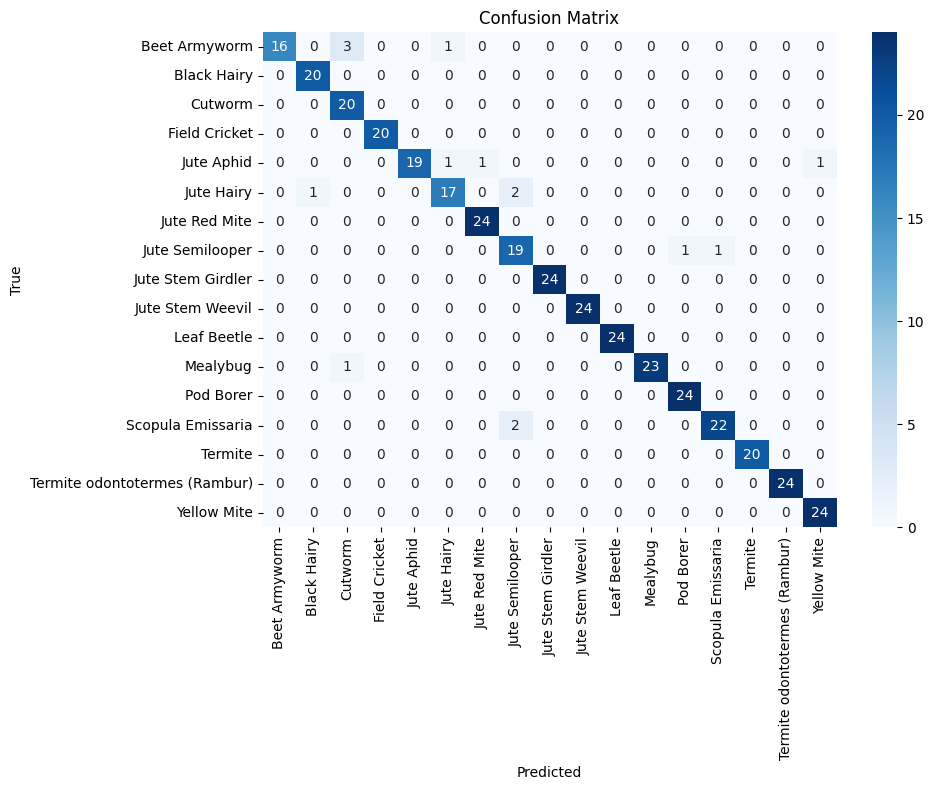


--- Sample Predictions (3 random classes) ---


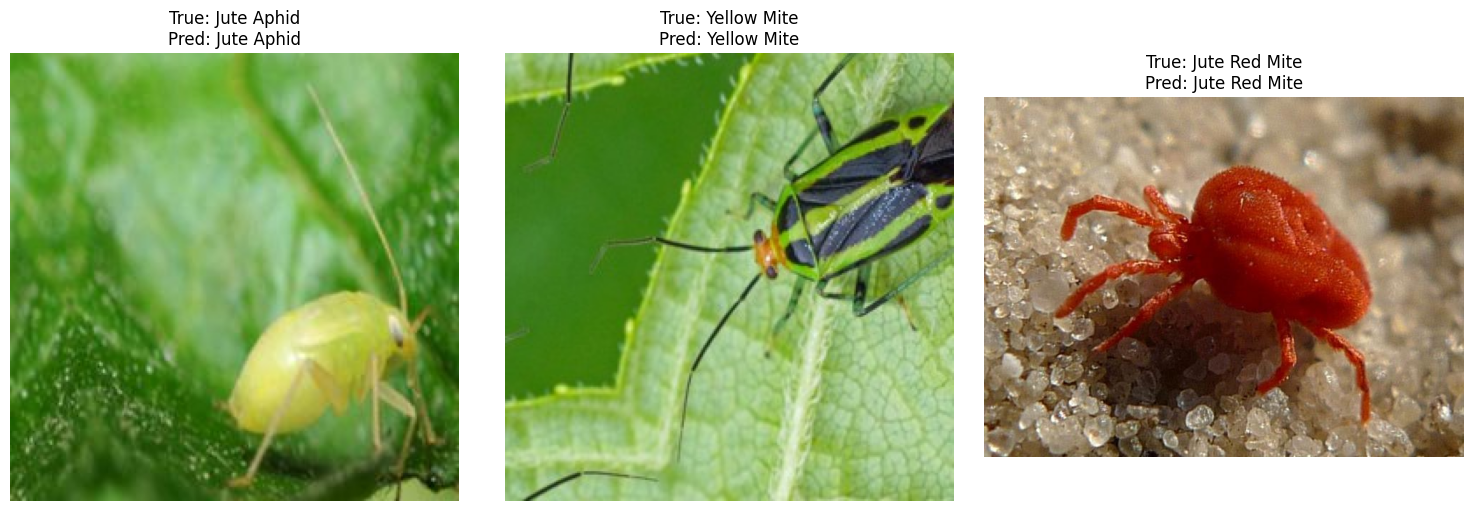

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        if phase == "train":
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "inceptionv3_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(299),
        transforms.RandomCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === InceptionV3 ===
model = models.inception_v3(pretrained=True, aux_logits=True)
for param in model.parameters():
    param.requires_grad = False
model.aux_logits = True
model.fc = nn.Linear(model.fc.in_features, len(datasets["train"].classes))
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_inceptionv3_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "inceptionv3_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "inceptionv3_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "inceptionv3_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "inceptionv3_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# **Xception**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
<ipython-input-1-ba676a8e6879>:163: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/202 [00:00<?, ?it/s]<ipython-input-1-ba676a8e6879>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.6726  Acc: 0.8207


Val Loss: 0.3554  Acc: 0.8910

Epoch 2/10 ====================


Train Loss: 0.0705  Acc: 0.9815


Val Loss: 0.3132  Acc: 0.9153

Epoch 3/10 ====================


Train Loss: 0.0276  Acc: 0.9935


Val Loss: 0.3269  Acc: 0.9104

Epoch 4/10 ====================


Train Loss: 0.0178  Acc: 0.9963


Val Loss: 0.3760  Acc: 0.9153

Epoch 5/10 ====================


Train Loss: 0.0137  Acc: 0.9977


Val Loss: 0.3744  Acc: 0.9128

Epoch 6/10 ====================


Train Loss: 0.0093  Acc: 0.9989


Val Loss: 0.3617  Acc: 0.9201

Epoch 7/10 ====================


Train Loss: 0.0056  Acc: 0.9994


Val Loss: 0.3565  Acc: 0.9153

Epoch 8/10 ====================


Train Loss: 0.0063  Acc: 0.9988


Val Loss: 0.3570  Acc: 0.9153

Epoch 9/10 ====================


Train Loss: 0.0056  Acc: 0.9992


Val Loss: 0.3619  Acc: 0.9153

Epoch 10/10 ====================


Train Loss: 0.0053  Acc: 0.9984


Val Loss: 0.3370  Acc: 0.9128

Training complete in 7m 51s
Best validation accuracy: 0.9201



--- Test Metrics ---
Test Accuracy : 0.9710
Precision     : 0.9769
Recall        : 0.9710
F1 Score      : 0.9712

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.90      0.95        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.87      1.00      0.93        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.74      1.00      0.85        20
                Jute Red Mite       1.00      1.00      1.00        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

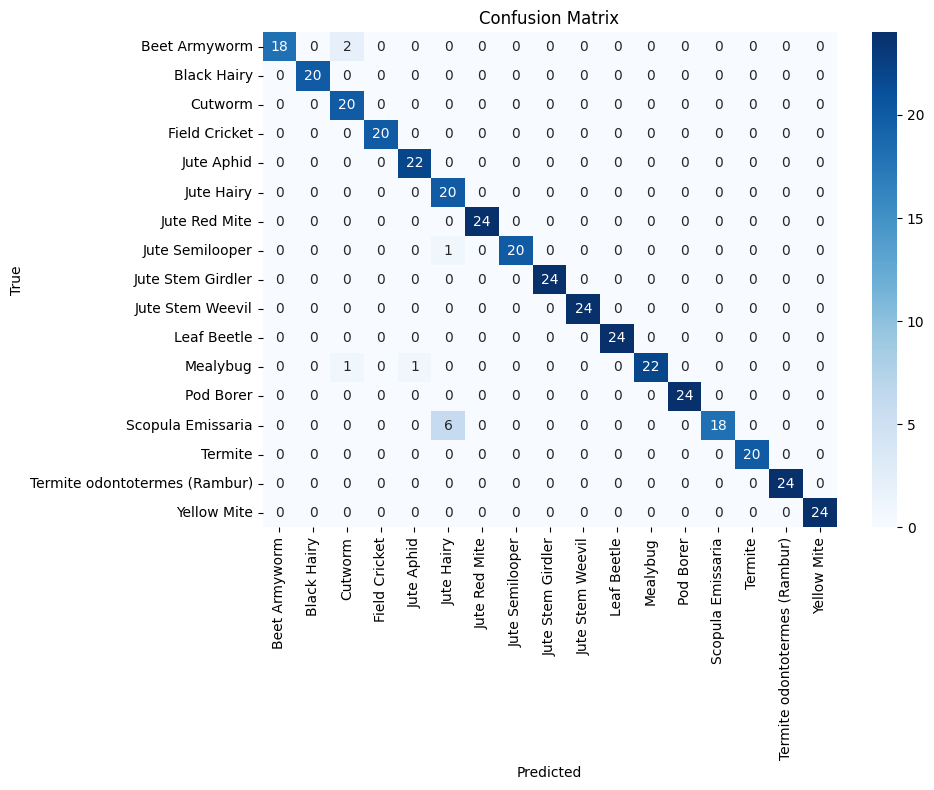


--- Sample Predictions (3 random classes) ---


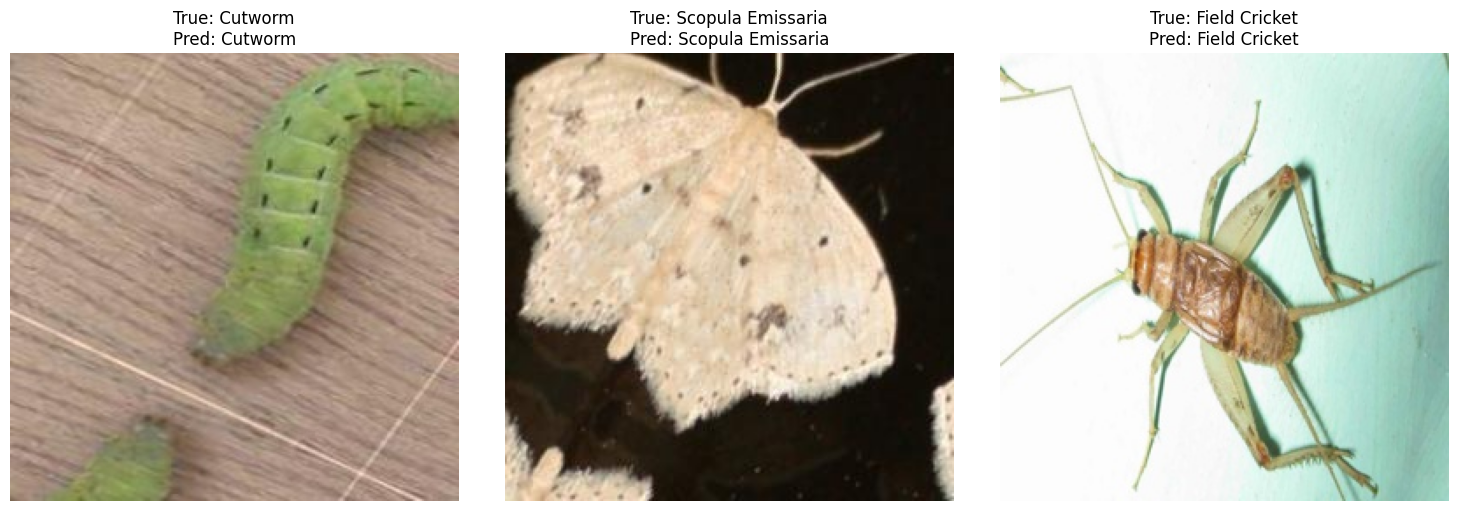

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

!pip install -q timm
import timm  # for Xception model

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "xception_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 32
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === Xception Model ===
model = timm.create_model("xception", pretrained=True, num_classes=len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_xception_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "xception_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "xception_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "xception_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "xception_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# **ShuffleNetV2**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `wei

Using device: cuda



100%|██████████| 8.79M/8.79M [00:00<00:00, 35.0MB/s]
<ipython-input-6-88d38c59fa93>:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-6-88d38c59fa93>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to r

Train Loss: 2.7984  Acc: 0.0973


Val Loss: 2.7390  Acc: 0.1719

Epoch 2/10 ====================


Train Loss: 2.7091  Acc: 0.1049


Val Loss: 2.5509  Acc: 0.1719

Epoch 3/10 ====================


Train Loss: 2.4980  Acc: 0.1866


Val Loss: 2.1587  Acc: 0.4334

Epoch 4/10 ====================


Train Loss: 2.0969  Acc: 0.4453


Val Loss: 1.6304  Acc: 0.5351

Epoch 5/10 ====================


Train Loss: 1.4761  Acc: 0.6640


Val Loss: 1.1788  Acc: 0.6804

Epoch 6/10 ====================


Train Loss: 0.8581  Acc: 0.8418


Val Loss: 0.8479  Acc: 0.7845

Epoch 7/10 ====================


Train Loss: 0.4606  Acc: 0.9089


Val Loss: 0.6375  Acc: 0.8184

Epoch 8/10 ====================


Train Loss: 0.2795  Acc: 0.9395


Val Loss: 0.5227  Acc: 0.8450

Epoch 9/10 ====================


Train Loss: 0.1898  Acc: 0.9600


Val Loss: 0.4375  Acc: 0.8692

Epoch 10/10 ====================


Train Loss: 0.1379  Acc: 0.9708


Val Loss: 0.4009  Acc: 0.8886

Training complete in 4m 60s
Best validation accuracy: 0.8886



--- Test Metrics ---
Test Accuracy : 0.9657
Precision     : 0.9710
Recall        : 0.9657
F1 Score      : 0.9635

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.55      0.71        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.77      1.00      0.87        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.88      1.00      0.94        22
                   Jute Hairy       1.00      0.90      0.95        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       0.91      1.00      0.95        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

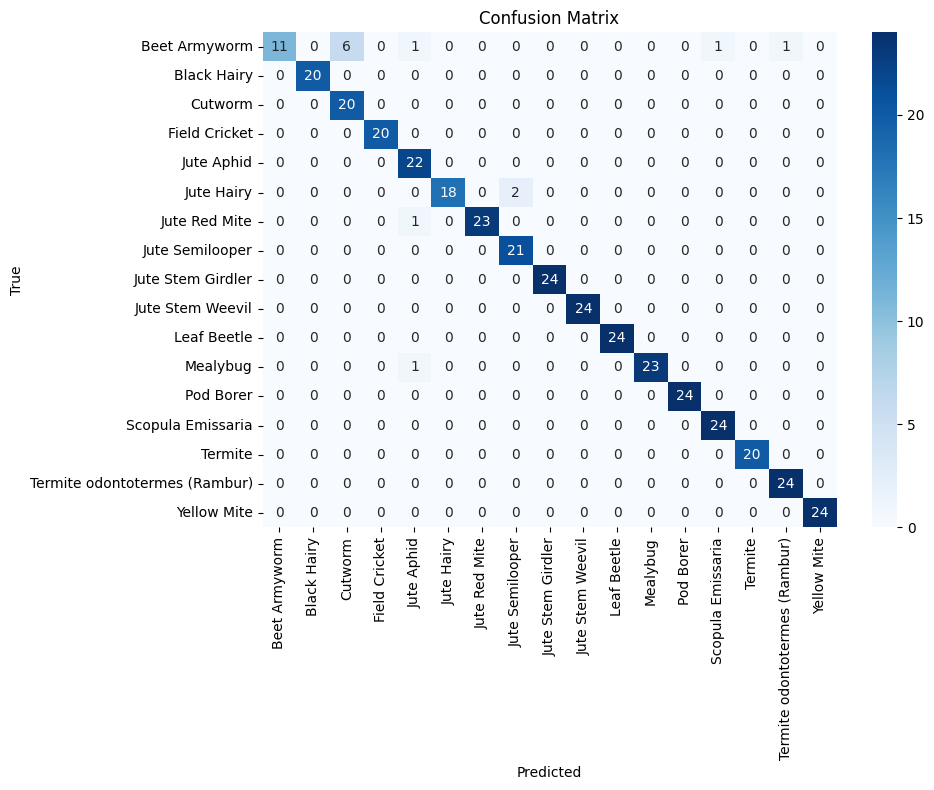


--- Sample Predictions (3 random classes) ---


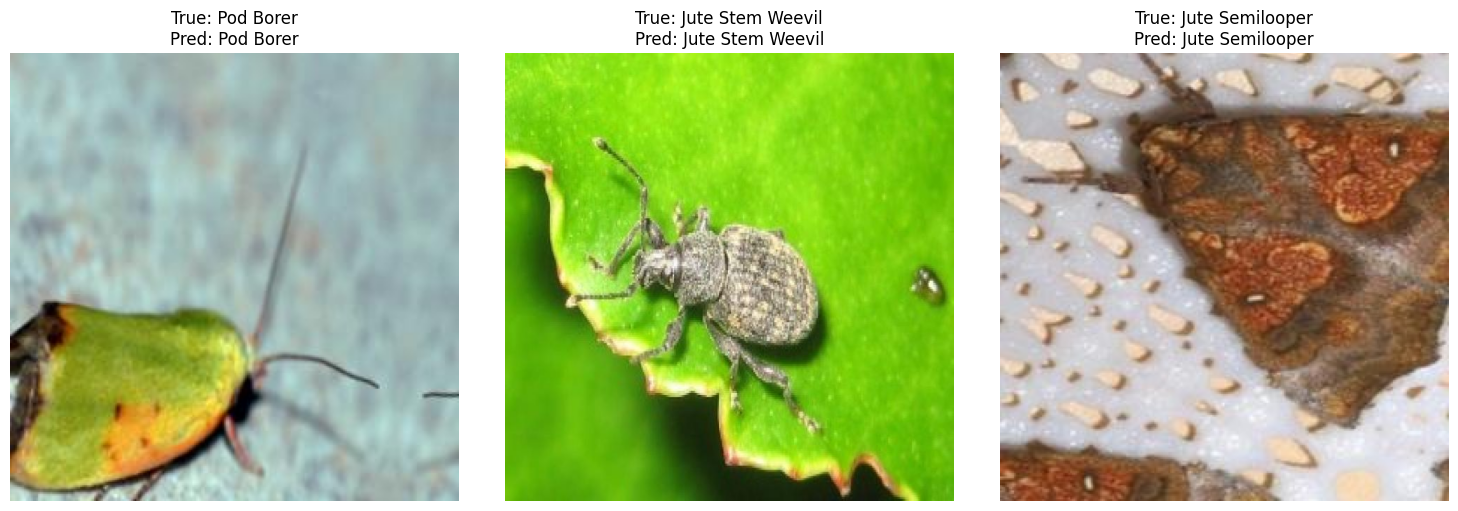

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "shufflenetv2_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === ShuffleNetV2 ===
model = models.shufflenet_v2_x1_0(pretrained=True)
for param in model.conv1.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_shufflenetv2_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "shufflenetv2_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "shufflenetv2_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "shufflenetv2_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "shufflenetv2_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# **SqueezeNet**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=

Using device: cuda



100%|██████████| 4.73M/4.73M [00:00<00:00, 29.9MB/s]
<ipython-input-7-d0729c284f29>:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-7-d0729c284f29>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.9250  Acc: 0.7417


Val Loss: 0.8004  Acc: 0.8015

Epoch 2/10 ====================


Train Loss: 0.3500  Acc: 0.9010


Val Loss: 0.7593  Acc: 0.8184

Epoch 3/10 ====================


Train Loss: 0.2355  Acc: 0.9331


Val Loss: 0.6221  Acc: 0.8499

Epoch 4/10 ====================


Train Loss: 0.1730  Acc: 0.9491


Val Loss: 0.6530  Acc: 0.8692

Epoch 5/10 ====================


Train Loss: 0.1464  Acc: 0.9553


Val Loss: 0.6401  Acc: 0.8644

Epoch 6/10 ====================


Train Loss: 0.1278  Acc: 0.9607


Val Loss: 0.6815  Acc: 0.8668

Epoch 7/10 ====================


Train Loss: 0.1091  Acc: 0.9666


Val Loss: 0.6735  Acc: 0.8499

Epoch 8/10 ====================


Train Loss: 0.1092  Acc: 0.9645


Val Loss: 0.6982  Acc: 0.8523

Epoch 9/10 ====================


Train Loss: 0.1058  Acc: 0.9649


Val Loss: 0.6051  Acc: 0.8862

Epoch 10/10 ====================


Train Loss: 0.0950  Acc: 0.9708


Val Loss: 0.6579  Acc: 0.8644

Training complete in 4m 30s
Best validation accuracy: 0.8862



--- Test Metrics ---
Test Accuracy : 0.9710
Precision     : 0.9713
Recall        : 0.9710
F1 Score      : 0.9706

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.89      0.85      0.87        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      0.95      0.95        20
                Field Cricket       0.95      1.00      0.98        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       1.00      0.90      0.95        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       0.95      0.95      0.95        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

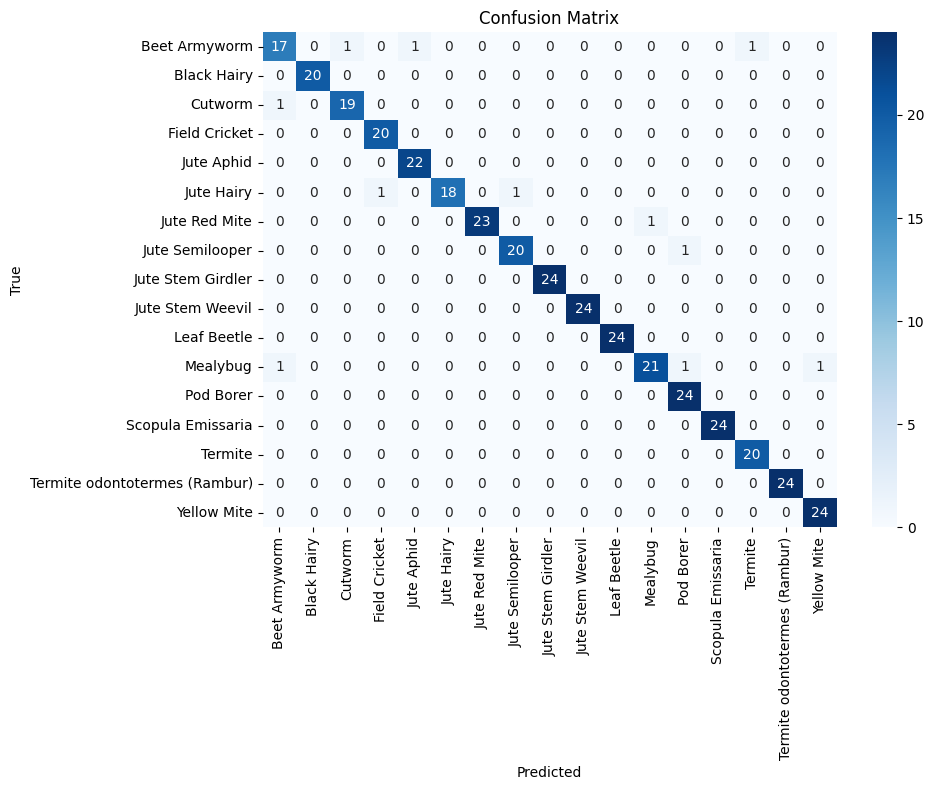


--- Sample Predictions (3 random classes) ---


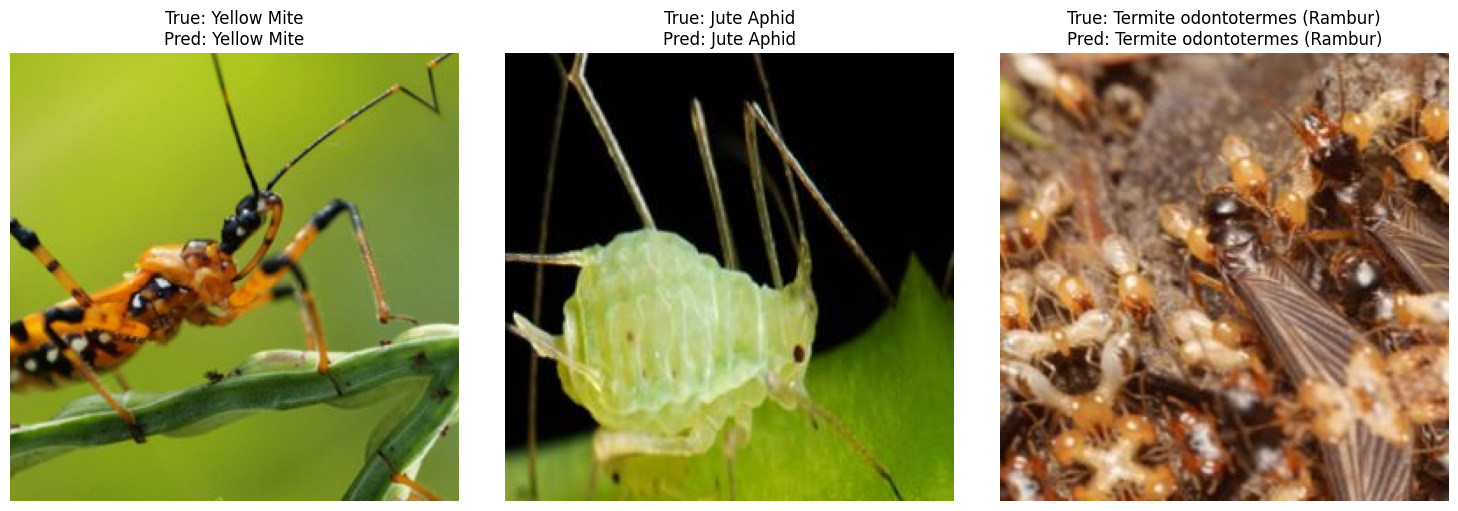

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "squeezenet_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === SqueezeNet ===
model = models.squeezenet1_1(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Conv2d(512, len(datasets["train"].classes), kernel_size=(1, 1), stride=(1, 1))
model.num_classes = len(datasets["train"].classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_squeezenet_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "squeezenet_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "squeezenet_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "squeezenet_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "squeezenet_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# **GhostNet**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

<ipython-input-10-c0f9e74a16f3>:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-10-c0f9e74a16f3>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to 

Train Loss: 0.9933  Acc: 0.7326


Val Loss: 0.3974  Acc: 0.8983

Epoch 2/10 ====================


Train Loss: 0.1189  Acc: 0.9708


Val Loss: 0.3221  Acc: 0.9177

Epoch 3/10 ====================


Train Loss: 0.0513  Acc: 0.9887


Val Loss: 0.2949  Acc: 0.9225

Epoch 4/10 ====================


Train Loss: 0.0301  Acc: 0.9941


Val Loss: 0.3046  Acc: 0.9322

Epoch 5/10 ====================


Train Loss: 0.0188  Acc: 0.9977


Val Loss: 0.3228  Acc: 0.9225

Epoch 6/10 ====================


Train Loss: 0.0130  Acc: 0.9984


Val Loss: 0.3331  Acc: 0.9153

Epoch 7/10 ====================


Train Loss: 0.0086  Acc: 0.9998


Val Loss: 0.3222  Acc: 0.9322

Epoch 8/10 ====================


Train Loss: 0.0098  Acc: 0.9983


Val Loss: 0.3148  Acc: 0.9322

Epoch 9/10 ====================


Train Loss: 0.0092  Acc: 0.9980


Val Loss: 0.3285  Acc: 0.9249

Epoch 10/10 ====================


Train Loss: 0.0083  Acc: 0.9986


Val Loss: 0.3324  Acc: 0.9298

Training complete in 5m 20s
Best validation accuracy: 0.9322



--- Test Metrics ---
Test Accuracy : 0.9815
Precision     : 0.9828
Recall        : 0.9815
F1 Score      : 0.9815

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.90      0.92        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.87      1.00      0.93        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.90      0.95        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

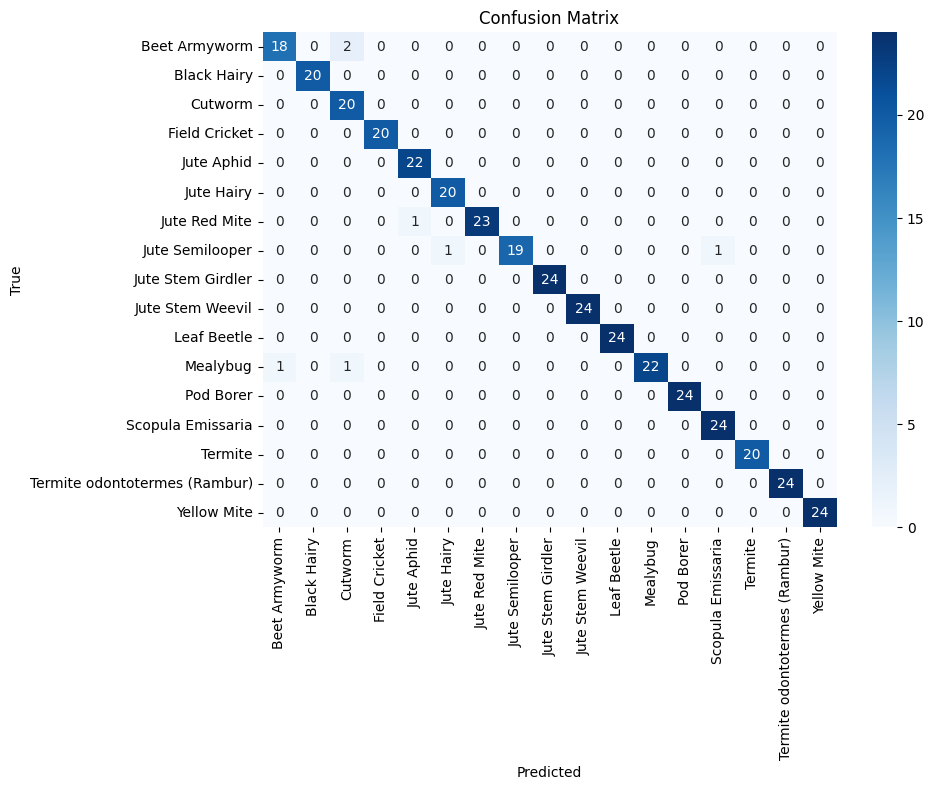


--- Sample Predictions (3 random classes) ---


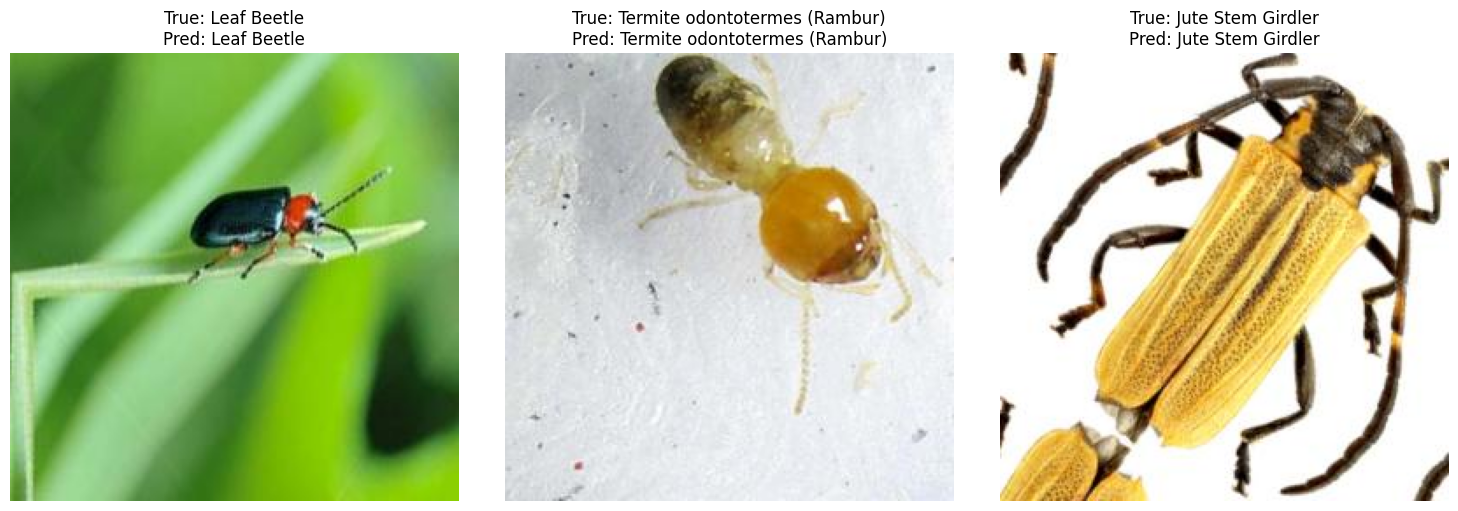

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Install timm ===
!pip install timm --quiet

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import timm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "ghostnet_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 2  # reduced for Colab
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True)
    for phase in ["train", "val", "test"]
}

# === GhostNet (via timm) ===
model = timm.create_model("ghostnet_100", pretrained=True, num_classes=len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_ghostnet_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "ghostnet_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "ghostnet_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "ghostnet_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "ghostnet_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)


# **RegNet**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/jute_pest_dataset’: File exists
Using device: cuda



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 88.8MB/s]
<ipython-input-9-aa7fa3a58685>:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  sc


Epoch 1/10 ====================


Epoch 1 Train:   0%|           | 0/101 [00:00<?, ?it/s]<ipython-input-9-aa7fa3a58685>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to r

Train Loss: 0.9823  Acc: 0.7292


Val Loss: 0.7607  Acc: 0.7458

Epoch 2/10 ====================


Train Loss: 0.3283  Acc: 0.9202


Val Loss: 0.5654  Acc: 0.8039

Epoch 3/10 ====================


Train Loss: 0.2449  Acc: 0.9446


Val Loss: 0.5208  Acc: 0.8450

Epoch 4/10 ====================


Train Loss: 0.2159  Acc: 0.9461


Val Loss: 0.5697  Acc: 0.8184

Epoch 5/10 ====================


Train Loss: 0.1833  Acc: 0.9548


Val Loss: 0.4733  Acc: 0.8499

Epoch 6/10 ====================


Train Loss: 0.1521  Acc: 0.9646


Val Loss: 0.5077  Acc: 0.8450

Epoch 7/10 ====================


Train Loss: 0.1446  Acc: 0.9655


Val Loss: 0.5189  Acc: 0.8426

Epoch 8/10 ====================


Train Loss: 0.1405  Acc: 0.9663


Val Loss: 0.4853  Acc: 0.8596

Epoch 9/10 ====================


Train Loss: 0.1291  Acc: 0.9708


Val Loss: 0.4637  Acc: 0.8692

Epoch 10/10 ====================


Train Loss: 0.1141  Acc: 0.9725


Val Loss: 0.4786  Acc: 0.8596

Training complete in 4m 42s
Best validation accuracy: 0.8692



--- Test Metrics ---
Test Accuracy : 0.9683
Precision     : 0.9698
Recall        : 0.9683
F1 Score      : 0.9682

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.90      0.95        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.86      0.95      0.90        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       0.95      1.00      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       0.96      1.00      0.98        24
                  Leaf Beetle       1.00      1.00      1.00        24
         

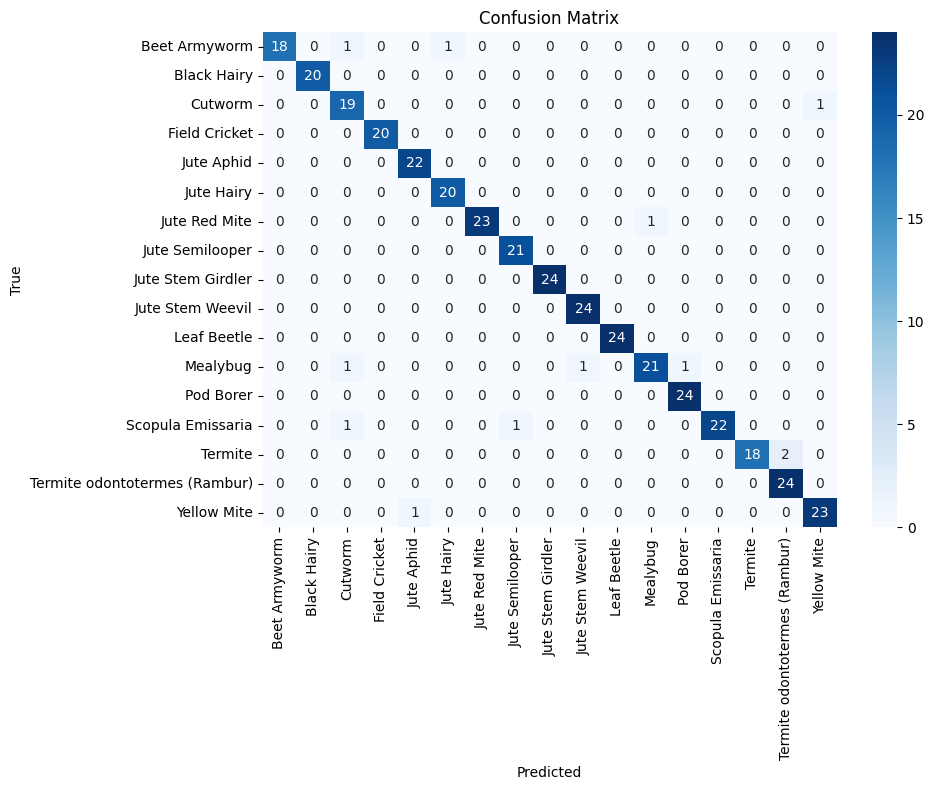


--- Sample Predictions (3 random classes) ---


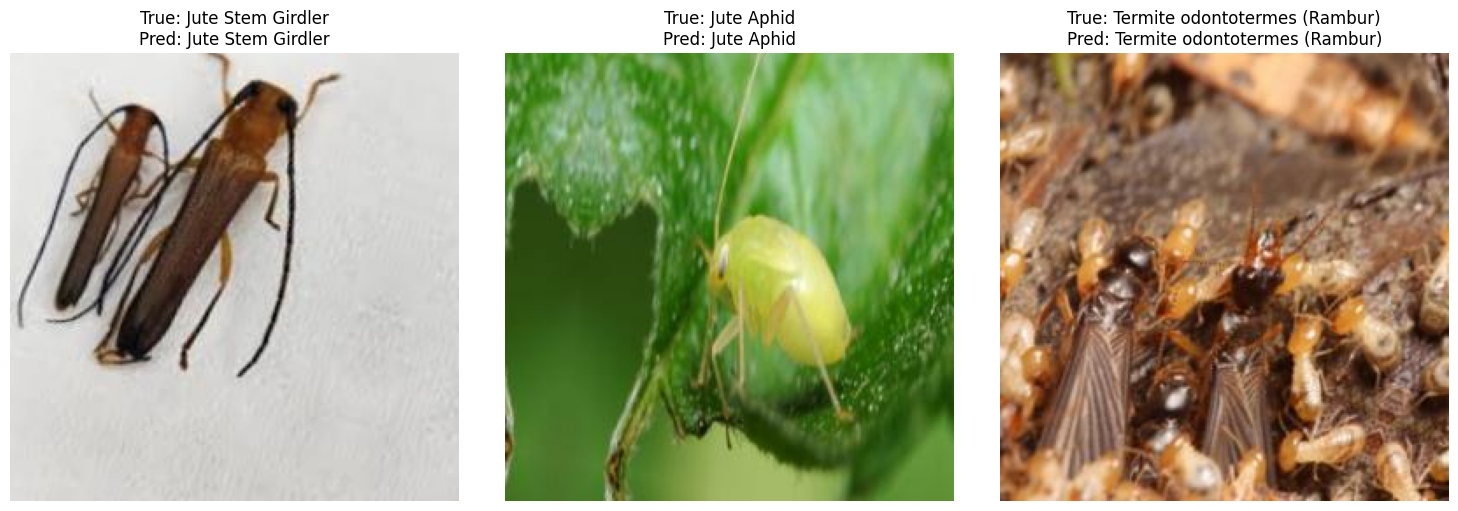

In [ ]:
# === Google Colab: Mount Drive and Copy Dataset ===
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/jute_pest_dataset
!cp -r /content/drive/MyDrive/Jute_Pest_Dataset/* /content/jute_pest_dataset/

# === Imports ===
import os, time, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

# === Paths ===
BASE_DIR = "/content/jute_pest_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# === Dataset Class ===
class JutePestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Training Function ===
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    since = time.time()
    best_acc = 0.0
    logs = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} " + "="*20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"Epoch {epoch+1} {phase.capitalize()}",
                        leave=False, dynamic_ncols=True,
                        bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]')

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            logs[phase].append({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_acc.item()})
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(BASE_DIR, "regnet_best_jute_pest_model.pth"))

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    return model, logs

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}\n")

# === Transforms ===
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# === Datasets & Dataloaders ===
datasets = {
    "train": JutePestDataset(TRAIN_DIR, transform=data_transforms["train"]),
    "val": JutePestDataset(VAL_DIR, transform=data_transforms["val"]),
    "test": JutePestDataset(TEST_DIR, transform=data_transforms["test"])
}

batch_size = 64
num_workers = 8
dataloaders = {
    phase: DataLoader(datasets[phase], batch_size=batch_size, shuffle=(phase=="train"),
                      num_workers=num_workers, pin_memory=True, persistent_workers=True, prefetch_factor=4)
    for phase in ["train", "val", "test"]
}

# === RegNet ===
model = models.regnet_y_400mf(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(datasets["train"].classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

# === Train ===
model, training_logs = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
torch.save(model.state_dict(), os.path.join(BASE_DIR, "final_regnet_jute_pest_model.pth"))

# === Test ===
model.eval()
test_results, all_preds, all_labels = [], [], []
correct, total, sample_idx = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloaders["test"], desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
            test_results.append({
                "image_path": datasets["test"].samples[sample_idx][0],
                "true_label": datasets["test"].classes[labels[i].item()],
                "predicted_label": datasets["test"].classes[predicted[i].item()]
            })
            sample_idx += 1

# Save Results
with open(os.path.join(BASE_DIR, "regnet_test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# === Metrics ===
print("\n--- Test Metrics ---")
print(f"Test Accuracy : {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision     : {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall        : {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print(f"F1 Score      : {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=datasets["test"].classes, zero_division=0))

# === Confusion Matrix ===
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=datasets["test"].classes,
            yticklabels=datasets["test"].classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "regnet_confusion_matrix.png"))
plt.show()

# === Random Predictions ===
chosen_classes = random.sample(datasets["test"].classes, 3)
chosen_samples = []

for cls in chosen_classes:
    cls_indices = [i for i, sample in enumerate(test_results) if sample["true_label"] == cls]
    if cls_indices:
        chosen_samples.append(test_results[random.choice(cls_indices)])

print("\n--- Sample Predictions (3 random classes) ---")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    sample = chosen_samples[i]
    img = Image.open(sample["image_path"])
    ax.imshow(img)
    ax.set_title(f"True: {sample['true_label']}\nPred: {sample['predicted_label']}")
    ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "regnet_sample_predictions.png"))
plt.show()

# === Save Logs ===
with open(os.path.join(BASE_DIR, "regnet_training_logs.json"), "w") as f:
    json.dump(training_logs, f, indent=4)
